Dielectric nano-sphere, constant index
============================

Comparing pyGDM to Mie theory for a constant ref.-index dielectric sphere (n=2, D=300nm).

At first we load the modules:

In [1]:
from pyGDM2 import structures
from pyGDM2 import materials
from pyGDM2 import fields

from pyGDM2 import core
from pyGDM2 import tools
from pyGDM2 import linear
from pyGDM2 import visu

import numpy as np
import matplotlib.pyplot as plt
import copy

## --- load pre-calculated Mie-data
wl_mie, qext_mie, qsca_mie = np.loadtxt("scat_mie_n2_D300nm.txt").T

Simulation setup
--------------------

We now create several simulations which calculate scattering spectra for nano-spheres using different discretization density and meshes. Then we compare the results to Mie theory.

In [2]:
#==============================================================================
# pyGDM setup
#==============================================================================
## ---------- Setup scale-factors for differntly fine meshes
## --- cubic mesh structures
factors_cube = [0.8, 1.0, 1.25]

## --- hexagonal mesh structures
factors_hex = [0.75, 1.0, 1.2]


#==============================================================================
# Setup incident field
#==============================================================================
field_generator = fields.planewave
## log-interval spectrum (denser at low lambda):
wavelengths = np.exp(np.linspace(np.log(300), np.log(1000), 30))
kwargs = dict(theta = [0.0])
efield = fields.efield(field_generator, wavelengths=wavelengths, kwargs=kwargs)


#==============================================================================
# Setup geometries and environment (spheres D=300nm, n=2, in vacuum)
#==============================================================================
material = materials.dummy(2.0)
n1, n2 = 1.0, 1.0     # vacuum environment

## --- cubic mesh
sim_cube = []
for fact in factors_cube:
    step = 37.5/fact
    radius = 4.*fact     # 37.5*4 = 150nm  -->  D=300nm
    geometry = structures.sphere(step, R=radius, mesh='cube')
    
    struct = structures.struct(step, geometry, material, n1,n2, 
                                   structures.get_normalization('cube'))
    
    sim = core.simulation(struct, efield) 
    sim_cube.append( copy.deepcopy(sim) )


## --- hexagonal mesh
sim_hex = []
for fact in factors_hex:
    step = 37.5/fact
    radius = 4.*fact
    geometry = structures.sphere(step, R=radius, mesh='hex', ORIENTATION=2)
    
    struct = structures.struct(step, geometry, material, n1,n2, 
                                   structures.get_normalization('hex'))
    
    sim = core.simulation(struct, efield) 
    sim_hex.append( copy.deepcopy(sim) )

Run the simulations
--------------------------

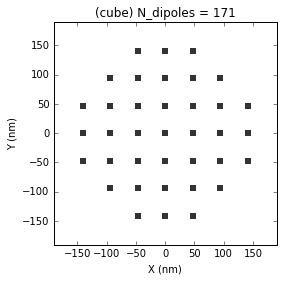

(cube) ----- N_dipoles = 171 done.


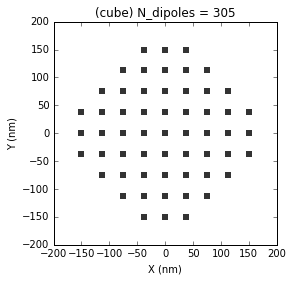

(cube) ----- N_dipoles = 305 done.


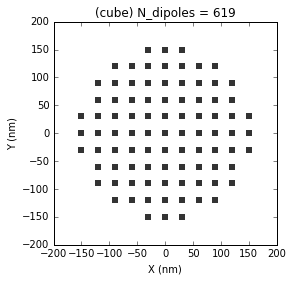

(cube) ----- N_dipoles = 619 done.


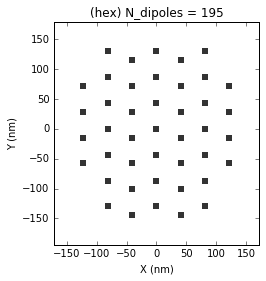

(hex) ----- N_dipoles = 195 done.


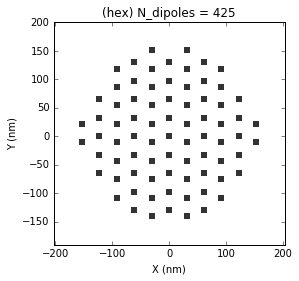

(hex) ----- N_dipoles = 425 done.


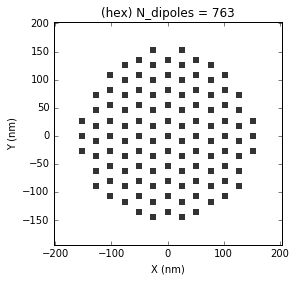

(hex) ----- N_dipoles = 763 done.


In [3]:
## --- cubic mesh
a_ext_cube = []
labels_cube = []
for sim in sim_cube:
    plt.figure()
    plt.title('(cube) N_dipoles = {}'.format(len(sim.struct.geometry)))
    visu.structure(sim)
    print '(cube) ----- N_dipoles =', len(sim.struct.geometry), 
    
    E = core.scatter(sim, method='lu', verbose=False)
    
    ## extinction spectrum
    field_kwargs = tools.get_possible_field_params_spectra(sim)[0]
    wl, spec = tools.calculate_spectrum(sim, field_kwargs, linear.extinct)
    a_ext = spec.T[0]
    a_geo = tools.get_geometric_cross_section(sim)
    
    a_ext_cube.append(a_ext/a_geo)
    labels_cube.append(len(sim.struct.geometry))
    print 'done.'


## --- hexagonal mesh
a_ext_hex = []
labels_hex = []
for sim in sim_hex:
    plt.figure()
    plt.title('(hex) N_dipoles = {}'.format(len(sim.struct.geometry)))
    visu.structure(sim)
    print '(hex) ----- N_dipoles =', len(sim.struct.geometry),
    
    E = core.scatter(sim, method='lu', verbose=False)

    ## extinction spectrum
    field_kwargs = tools.get_possible_field_params_spectra(sim)[0]
    wl, spec = tools.calculate_spectrum(sim, field_kwargs, linear.extinct)
    a_ext = spec.T[0]
    a_geo = tools.get_geometric_cross_section(sim)
    
    a_ext_hex.append(a_ext/a_geo)
    labels_hex.append(len(sim.struct.geometry))
    print 'done.'

Plot the spectra
---------------------------

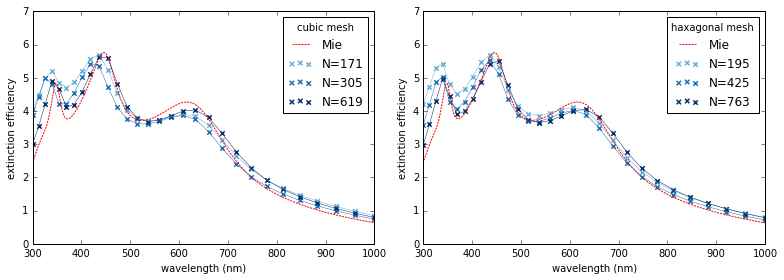

In [4]:
plt.figure(figsize=(11,4))


## --- cubic
plt.subplot(121)
plt.plot(wl_mie, qext_mie, 'r--', dashes=[2,1],label='Mie')

colors = plt.cm.Blues( np.linspace(0.5, 1.0, len(a_ext_cube)) )
for i, (ae, lab) in enumerate(zip(a_ext_cube, labels_cube)):
    c = colors[i]
    lab='N={}'.format(lab)
    plt.plot(wl, ae, color=c, lw=0.5)
    plt.scatter(wl, ae, marker='x', linewidth=1.5, color=c, label=lab)

plt.legend(loc='best', fontsize=12, title='cubic mesh')
plt.xlabel("wavelength (nm)")
plt.ylabel("extinction efficiency")
plt.xlim( [wl.min(), wl.max()] )


## --- hexagonal
plt.subplot(122)
plt.plot(wl_mie, qext_mie, 'r--', dashes=[2,1],label='Mie')

colors = plt.cm.Blues( np.linspace(0.5, 1.0, len(a_ext_hex)) )
for i, (ae, lab) in enumerate(zip(a_ext_hex, labels_hex)):
    c = colors[i]
    lab='N={}'.format(lab)
    plt.plot(wl, ae, color=c, lw=0.5)
    plt.scatter(wl, ae, marker='x', linewidth=1.5, color=c, label=lab)

plt.legend(loc='best', fontsize=12, title='haxagonal mesh')
plt.xlabel("wavelength (nm)")
plt.ylabel("extinction efficiency")
plt.xlim( [wl.min(), wl.max()] )


plt.tight_layout()
plt.show()

Looks as if already quite a few meshpoints are sufficient for an OK agreement with Mie theory.